In [1]:
play = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os, sys, camb
from camb import model, initialpower
from astropy import units as u, constants as c
from scipy.interpolate import interp1d

import utils as ut
import props as p
import lines as l
from importlib import reload
reload(ut)
reload(p)
reload(l)

<module 'lines' from 'C:\\Users\\juzz\\Desktop\\TIM\\LIMxJuzz\\LIM\\TIMxGal\\lines.py'>

In [3]:

#TIM = p.SpaceTIM
TIM = p.TIM
#TIM = p.TIM2


#GAL = p.AstroDeep
GAL = p.Euclid
CII = l.CII

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h

sigCoef = np.sqrt(8*np.log(2))
lilh = True

dlnk = 0.8

if play:
    dlnk = 1

colors = ['purple', 'blue', 'gold', 'red']
linestyles = ['-','--',':','-.']

In [4]:
# define our bins
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]

bin_zs = [b.center.value for b in bins]

bands = ['SW', 'SW', 'LW', 'LW'] 

print("TIM bins:")
for b in bins:
    print(f"z in [{b.front:.3f}, {b.back:.3f}]")

TIM bins:
z in [0.521, 0.766]
z in [0.766, 1.010]
z in [1.010, 1.336]
z in [1.336, 1.663]


In [5]:
LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]
# LIM survey objects for each bin

for lsb in LSbins:
    print(lsb.cell_noise(TIM.time))

220898022790.44324 Jy2 Mpc3 / s2
418341284343.32904 Jy2 Mpc3 / s2
248498105175.97574 Jy2 Mpc3 / s2
380653079150.8324 Jy2 Mpc3 / s2


In [6]:
LSbins[1].ins

In [7]:
#Sanity check on the kscale of the bin LoS
for lsb in LSbins:
    print(np.around(lsb.LoS, 2), 'or k = ', np.around(2*np.pi / lsb.LoS, 4))

508.99 Mpc or k =  0.0123 1 / Mpc
439.17 Mpc or k =  0.0143 1 / Mpc
497.76 Mpc or k =  0.0126 1 / Mpc
416.27 Mpc or k =  0.0151 1 / Mpc


In [8]:
k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

print(len(k_xyz_modes))
[print(kxyzs.shape) for kxyzs in k_xyz_modes]

4
(3, 20, 102, 39)
(3, 20, 102, 29)
(3, 15, 77, 39)
(3, 15, 77, 30)


[None, None, None, None]

In [9]:
# magnitudes of the k vectors
k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 

# minimum k magnitude in each survey bin
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]

# unit kx, ky, kz vectors for each mode in each survey bin
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# num of k bins given our dlnk
num_kbins = [round(ut.num_log_steps(k_min, np.max(km), dlnk)) + 1 \
    for k_min, km in zip(k_mins, k_mags)]

num_kbins

C:\Users\juzz\AppData\Local\Temp\ipykernel_33152\2981313433.py:9: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]


[13, 12, 12, 11]

In [10]:
# resolution elements Sigma_perpendicular (transverse) and sigma_par (LoS)
s_perps = [b.transScale(TIM[band].FWHM).value / sigCoef for b, band in zip(bins, bands)]
s_pars = [ut.dnu2dr(TIM[band].dnu, b.center).value / sigCoef for b, band in zip(bins, bands)]

In [11]:
s_perps

[0.11755244692217426,
 0.1516503189988713,
 0.24571221408768276,
 0.28908943552124405]

In [12]:
# outer product of the these three gaussians
windows = [np.einsum('i,j,k->ijk', 
                np.exp(-kxyzs[0][:, 0, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[1][0, :, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[2][0, 0, :]**2 * s_par**2 / 2)) 
                for kxyzs, s_perp, s_par in zip(k_xyz_modes, s_perps, s_pars)]

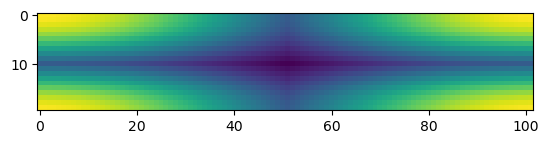

In [13]:
plt.figure()
plt.imshow(windows[0][:, :, 0])
plt.show()
plt.close()

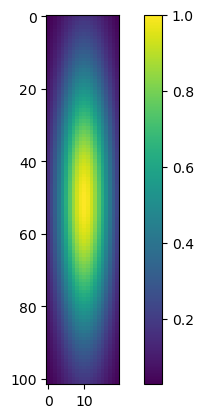

In [14]:
plt.figure()
plt.imshow(np.fft.fftshift(windows[0][:, :, 0]).T ** 2)
plt.colorbar()
plt.show()
plt.close()

In [15]:
# CAMB time, have to remove last redshift because there is a duplication
# and CAMB doesn't like that

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, As=2e-9, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.set_matter_power(redshifts=bin_zs[:-1], kmax=np.max(k_maxs) * 3, nonlinear=False) 


results = camb.get_results(pars)

Note: redshifts have been re-sorted (earliest first)


In [16]:
bin_zs

[0.6435273234436414,
 0.8875998478508937,
 1.1728794218333967,
 1.4993660453911497]

In [17]:
binned_results = [results.get_matter_power_spectrum(minkh=kmin, maxkh=np.max(km), npoints=nkb) \
    for kmin, km, nkb in zip(k_mins, k_mags, num_kbins)]

z_idxs = [np.argmin(np.abs(zs - binz)) for (_, zs, _), binz in zip(binned_results, bin_zs)]
print(z_idxs)

Pms = [(ks, Pm[z_idx]) for (ks, _, Pm), z_idx in zip(binned_results, z_idxs)]

[0, 1, 2, 2]


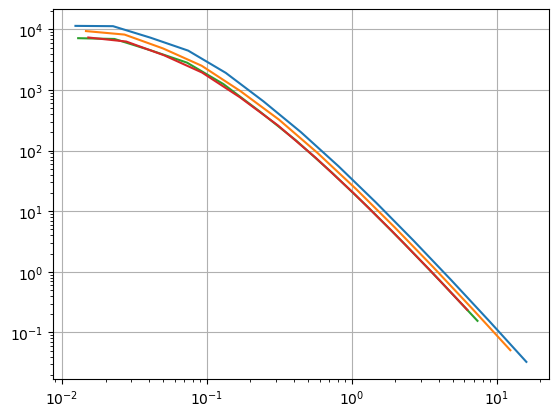

In [18]:
[plt.loglog(ks,Pm) for (ks, Pm) in Pms]
plt.grid()

In [19]:
kbin_edges = [np.append([0], np.sqrt(ks * np.append(ks[1:], [np.max(km)])))
            for km, (ks, _) in zip(k_mags, Pms)]
# get bin edges by selecting the midway between each CAMB k prediction
# use geometric mean because bins are log-spaced

nModes = []
for j, (ks,ws) in enumerate(zip(k_mags, windows)):
    kflat = ks.flatten()
    wflat = ws.flatten()
    kNonZero = kflat[np.nonzero(kflat)[0]]
    edges = kbin_edges[j]
    
    nModeList = []
    for i in np.arange(len(edges)-1):
        #print(i, len(edges))
        if i+1 == len(edges):
            wSum = (np.sum(wflat[kflat>edges[i]]))
        else:
            wSum = (np.sum(wflat[(kflat>edges[i]) & (kflat<=edges[i+1])]))
        nModeList.append(wSum/2.) # accounting for double counting.
    nModeList = np.asarray(nModeList)
    nModes.append(np.asarray(nModeList))

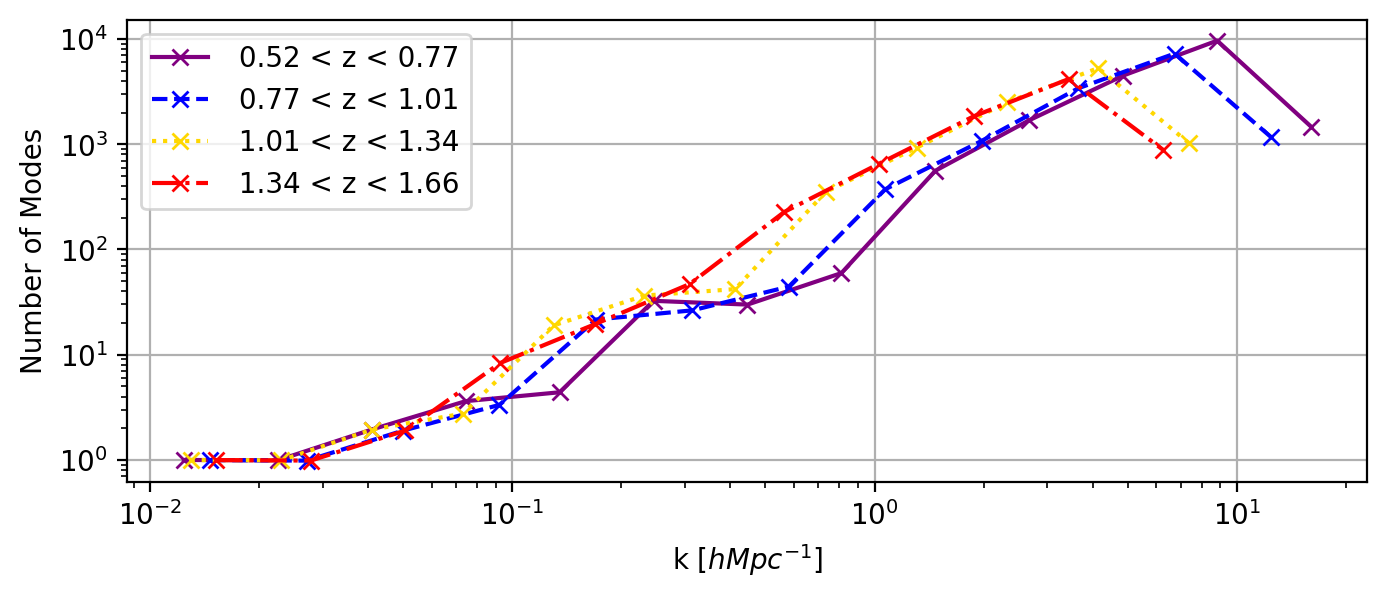

In [20]:
plt.figure(dpi = 200, figsize = (8,3))
for i,((ks,_),nums, col) in enumerate(zip(Pms,nModes, colors)):
    plt.loglog(ks,nums, color = col, linestyle = linestyles[i], marker = 'x',
               label = f" {bins[i].front:.2f} < z < {bins[i].back:.2f}")

plt.xlabel(r"k [$h Mpc^{-1}]$", size=10)
plt.ylabel('Number of Modes')

plt.grid()
plt.legend()

In [21]:
window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
                for i in range(len(kb)-1)]) 
        for win, km, kb in zip(windows, k_mags, kbin_edges)]

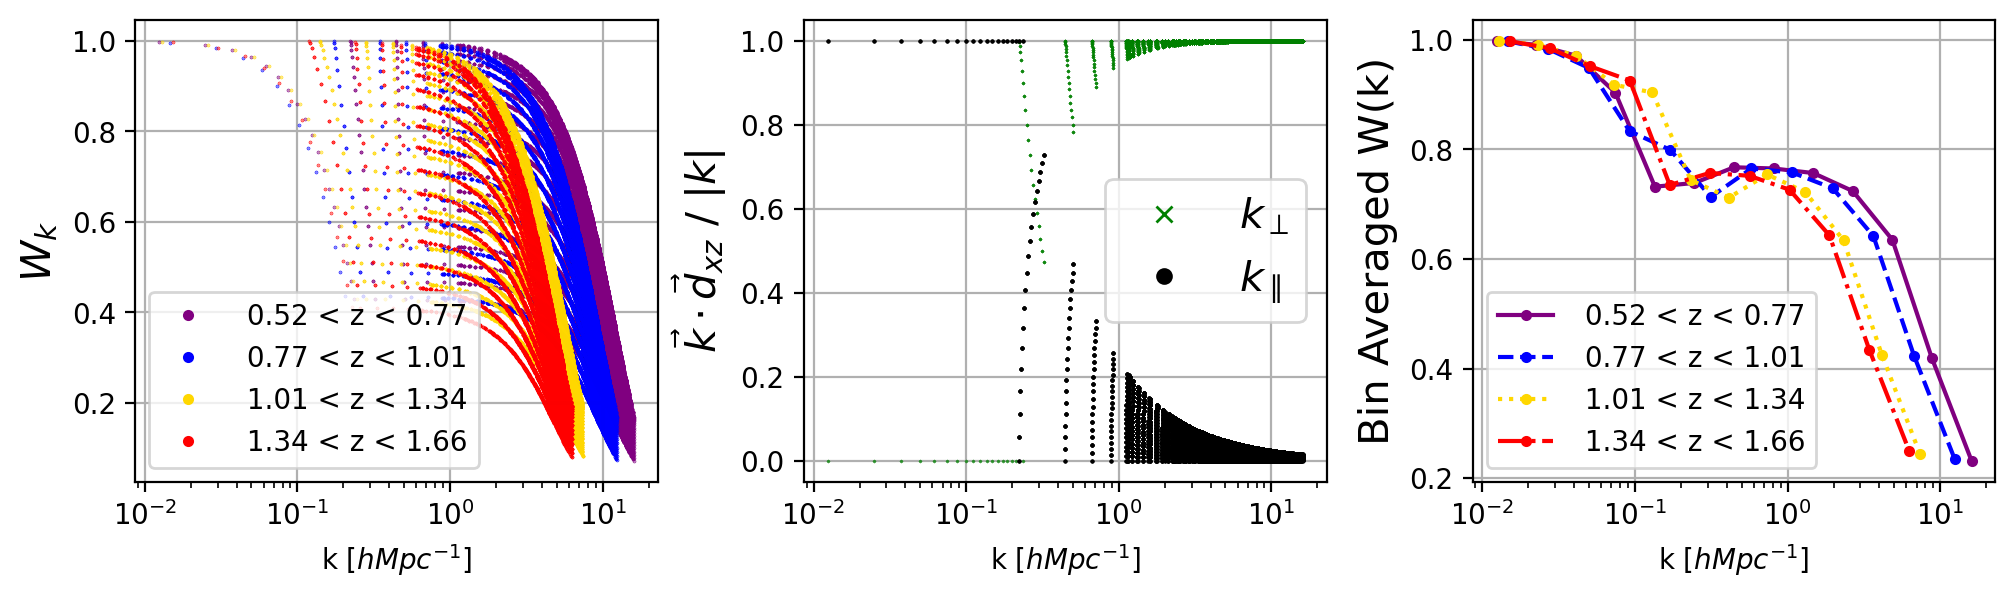

In [22]:
fig, (scatter, component, ave) = plt.subplots(1,3, figsize = (12,3), dpi = 200)#, sharex = True)

for i in range(len(k_mags)):
    scatter.semilogx(k_mags[i].flatten(), windows[i].flatten(), marker='.', \
    linestyle='None', label = f" {bins[i].front:.2f} < z < {bins[i].back:.2f}", markersize=.6, color = colors[i], alpha = .5)
scatter.grid()
scatterLeg = scatter.legend(markerscale = 10)
for lh in scatterLeg.legend_handles:
    lh.set_alpha(1)

for i in range(len(Pms)):
    ave.semilogx(Pms[i][0], window_avgs[i], label = f" {bins[i].front:.2f} < z < {bins[i].back:.2f}", marker='.', 
             color = colors[i], linestyle = linestyles[i] )
    
    
ave.grid()
ave.legend()
    

# making a plot for bin1
component.semilogx(k_mags[0].flatten(), (k_props[0][0] ** 2 + k_props[0][1] ** 2).flatten(), marker='x',
               linestyle='None', markersize=.6, alpha = 0.5, label = r'$k_{\perp}$', color = 'green')
component.semilogx(k_mags[0].flatten(), k_props[0][2].flatten(), marker='.', linestyle='None', 
               markersize=1, label = r'$k_{\parallel}$', color = 'black')
component.grid()
compLeg = component.legend(fontsize = 15, markerscale = 10)
for lh in compLeg.legend_handles:
    lh.set_alpha(1)
#compLeg.legendHandles[0]._legmarker.set_markersize(6)
#compLeg.legendHandles[1]._legmarker.set_markersize(6)

scatter.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
component.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
ave.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)

component.set_ylabel(r'$ \vec{k} \cdot \vec{d}_{xz}$ / $|k|$', fontsize = 15)
scatter.set_ylabel(r'$W_k$', fontsize = 15)
ave.set_ylabel('Bin Averaged W(k)', fontsize = 15)
fig.subplots_adjust(hspace=0, wspace=0.28)

In [23]:
sfrds = [ut.MD_sfrd(z) for z in bin_zs]
Iciis = np.array([CII.Inu(sfrd, z).value for sfrd, z in zip(sfrds, bin_zs)])

In [24]:
fs = 0.897 #Proportion of Galaxy sample galaxies that are line emitters
#TODO- Juzz - Recall where we got this number.
b_CII = 1.7 # TODO: Get an actual value for this and Bgal
b_gal = 1.7 # maintaining b* = b_CII*b_gal = 3
Igal = 1
bstar = b_CII*b_gal

x_shots = fs * Iciis / GAL.n_gals # cross shot for TIMxGal
#where fs is SFRD from the catalogue divided by the corresponding madau dickinson curve point.
PxGs = [(bstar * Icii * Igal * Pm) + x_shot 
            for Icii, x_shot, (_, Pm) in zip(Iciis, x_shots, Pms)]


In [25]:
x_shots

array([147619.42691558, 236401.48333171, 353953.75946212, 521982.50630284])

The following cell will calculate CII auto power spectra and galaxy survey auto power to use in the $\sigma_P$ calculation.
Here $\sigma_P \equiv \sqrt{VAR[P_x]}$:

$$VAR[P_x] = \frac{1}{2N_{mode}} [P^2_x + (P_{[CII]} + \frac{P_N}{W}) \cdot (P_{Gal} + \frac{1}{n_{gal}})]$$

OR

$$VAR[P_x] = \frac{1}{2N_{mode}} [P^2_x + (P_N + P_{[CII]}) \cdot (P_{Gal} + \frac{1}{n_{gal}})]$$
but where $$N_{mode} = \int dk^3 W_{TIM}(k_x, k_y, k_z) \cdot W_{GAL}(k_x, k_y, k_z) $$

So, an issue: here the dk cubed gives units of inverse volume where Nmodes should be unitless. Should there be some normalization here that cancels the volume units?

~*Breysse and Alexandroff 2019*

In [26]:
#### Trying to add in variance terms


TIM_shot = [1.2e9,2.2e9,3e9,3e9] # TODO: Discuss a self consistent way of calculating these values.

P_TIM = [(b_CII**2 * ICII**2 * Pm + shot) for ICII, (_,Pm), shot in zip(Iciis, Pms, TIM_shot)]
N_TIM = [lsb.cell_noise(TIM.time).value for lsb, nm in zip(LSbins, nModes)]

var_TIM = [(PT + NT)**2/n for PT, NT,n in zip(P_TIM, N_TIM, nModes)]

P_gal = [b_gal**2*Pm for (_,Pm), ngal in zip(Pms, GAL.n_gals)]
SNR_TIM = [PT/np.sqrt(var) for PT, var in zip(P_TIM, var_TIM)] #This needs some nm and w factors added.

In [27]:
clusterVar = [PT*PG/n
            for PT, n, PG in zip(P_TIM, nModes, P_gal)]

In [28]:
[print(PT/NT) for PT, NT in zip(P_TIM, N_TIM)]

[0.84649294 0.83695615 0.54154823 0.33373448 0.146517   0.05341278
 0.02027069 0.009497   0.006453   0.00567238 0.00548603 0.0054439
 0.00543477]
[0.5279207  0.46296837 0.2751697  0.14518943 0.05890607 0.02339825
 0.01037442 0.00655465 0.00556179 0.00532551 0.00527286 0.0052617 ]
[0.86429453 0.83894138 0.54859558 0.34821876 0.16126033 0.06481751
 0.02959987 0.01715949 0.01342961 0.01241185 0.01215324 0.01209099]
[0.60133594 0.51707084 0.30959973 0.16487901 0.06917187 0.02900784
 0.01402996 0.00948556 0.00826797 0.00796902 0.00790024]


[None, None, None, None]

In [29]:
def galCross_Variance(ngal, numModes, Px, Pg, Pl, Nl):
    crossVar = [(PxG**2 + (NT + PT) * (1/n_gal +Pg)) / (2*nm)
        for n_gal, nm, PxG, Pg, PT, NT in zip(ngal, numModes, Px, Pg, Pl, Nl)]
    return crossVar

In [30]:
VARx = galCross_Variance(GAL.n_gals, nModes, PxGs, P_gal, P_TIM, N_TIM)
SNR_PxG = [PxG / np.sqrt(VARs)  for PxG, VARs in zip(PxGs, VARx)]

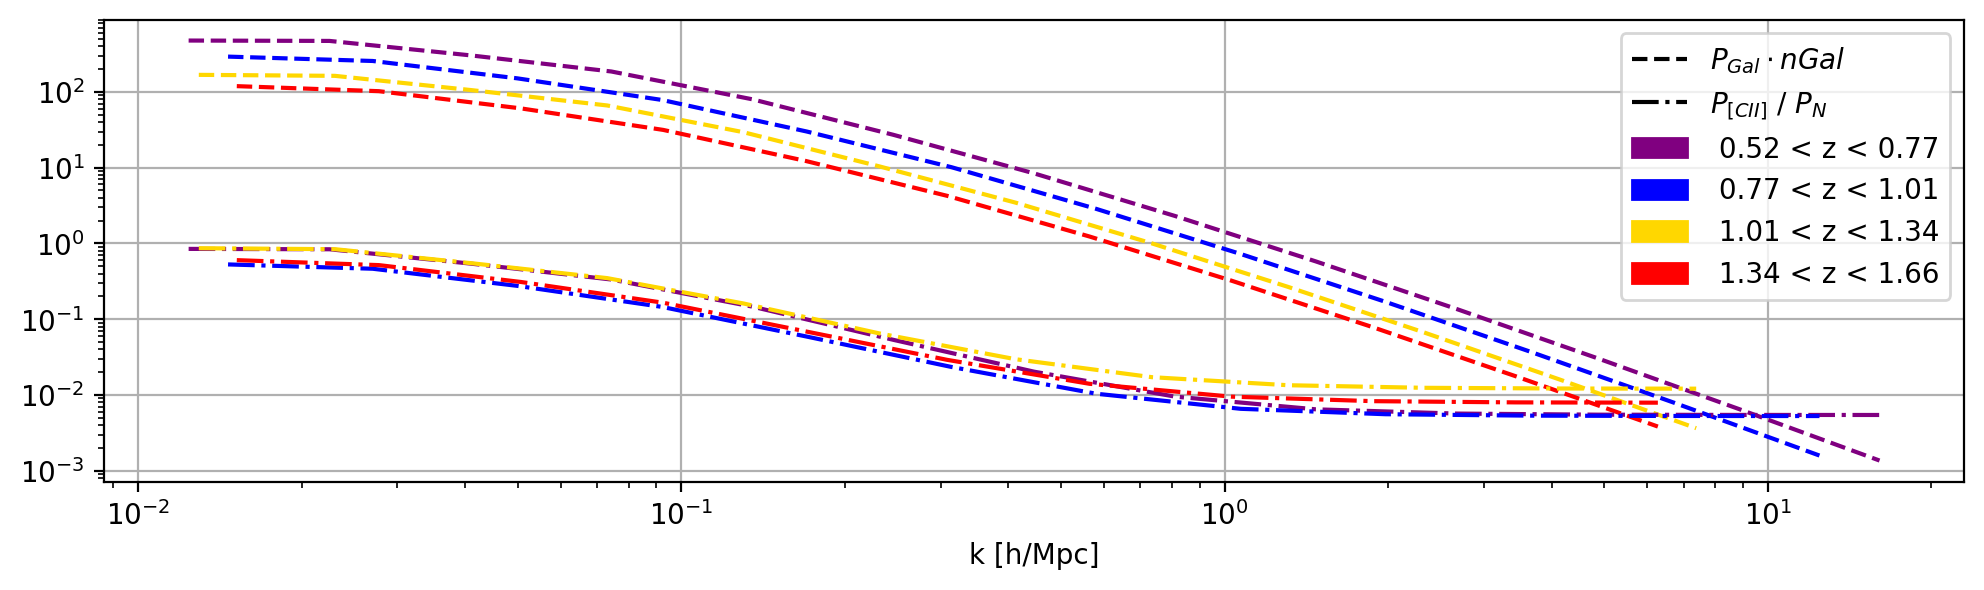

In [31]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

plt.figure(dpi = 200, figsize = (12,3))
[plt.loglog(ks, Pg/(1/ng), color = colors[i], ls = '--', label = r'P_{Gal} nGal') for i,((ks,_), Pg, ng) in enumerate(zip(Pms, P_gal, GAL.n_gals))]
#[plt.loglog(ks, SNRPxG, color = colors[i]) for i,((ks,_), SNRPxG) in enumerate(zip(Pms, SNR_PxG))]
[plt.loglog(ks, PT/NT, color = colors[i], ls = '-.', label = r'$P_{[CII]} / P_N$') 
     for i,((ks,_), PT, NT) in enumerate(zip(Pms, P_TIM, N_TIM))]
#[plt.axhline(1/ng, color = colors[i], ls = ':') for i,ng in enumerate(GAL.n_gals)]
#[plt.axhline(NT, color = colors[i], ls = '-.') for i,NT in enumerate(N_TIM)]

#dash = mpatches.Patch(color='black', ls = '--', label=r'$P_{Gal} nGal$')

plt.xlabel('k [h/Mpc]')
dash = mlines.Line2D([], [], color='black', marker='', ls = '--', label=r'$P_{Gal} \cdot nGal$')
dashDot = mlines.Line2D([], [], color='black', marker='', ls = '-.', label= r'$P_{[CII]}$ / $P_N$')
purple = mpatches.Patch(color='purple', label=f" {bins[0].front:.2f} < z < {bins[0].back:.2f}")
blue = mpatches.Patch(color='blue', label=f" {bins[1].front:.2f} < z < {bins[1].back:.2f}")
gold = mpatches.Patch(color='gold', label=f" {bins[2].front:.2f} < z < {bins[2].back:.2f}")
red = mpatches.Patch(color='red', label=f" {bins[3].front:.2f} < z < {bins[3].back:.2f}")

plt.legend(handles=[dash, dashDot, purple, blue, gold, red])
#plt.legend(handles=[dashDot])
plt.grid()

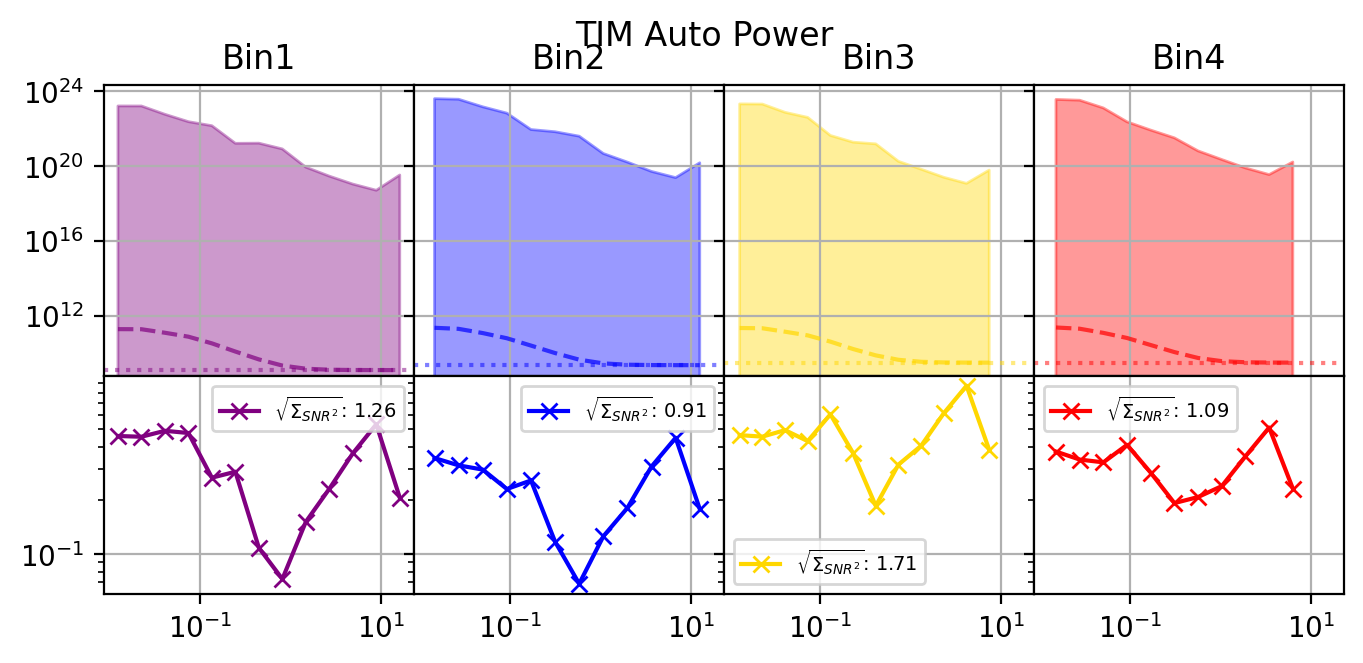

In [32]:
fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)
quad_SNR_TIM = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_TIM]

for i, PT in enumerate(P_TIM):
    power[i].loglog(Pms[i][0], PT, color = colors[i], linestyle = '--', alpha = .7)
    power[i].axhline(TIM_shot[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], PT + var_TIM[i],
                   PT - var_TIM[i], color = colors[i], alpha = .4)
    power[i].set_title('Bin'+str(i+1))

    SNR[i].loglog(Pms[i][0], SNR_TIM[i], color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_SNR_TIM[i],2)))
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    #SNR[i].set_yticks(np.arange(0, 26, 4.0))

fig.subplots_adjust(hspace=0, wspace=0)

fig.suptitle('TIM Auto Power')
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

In [33]:
#CAMB outputs lists of different ks for each bin so we can't sum them 'apples to apples.'
#So, we'll interpolate Cross powers, SNRs and noise values at matching ks across all bins.

PxG_Interp = [interp1d(ks, PxG) for (ks, _), PxG in zip(Pms, PxGs)]
SNR_PxG_Interp = [interp1d(ks, SNR) for (ks, _), SNR in zip(Pms, SNR_PxG)]
x_noise_Interp = [interp1d(ks, np.sqrt(VARs)) for (ks, _), VARs in zip(Pms, VARx)]

k4 = Pms[3][0] #isolate the list of k modes in bin 4. We'll use that as our default k list. 
aligned_PxGs = [interp(k4) for interp in PxG_Interp] #Interpolate the forecast signals in all bins at the modes in k4.
aligned_SNRs = np.nan_to_num([interp(k4) for interp in SNR_PxG_Interp]) #same for SNRs - nanToNum sets NaNs = 0.
aligned_x_noises = [interp(k4) for interp in x_noise_Interp]#and x_noises.

In [34]:
#sum the SNRs in each bin in quadrature so that we can report a "Total SNR per redshift bin"
quad_SNRs = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_PxG]

clustSNRs = [SNR[ks <= 1] for (ks,_), SNR in zip(Pms, SNR_PxG)]
quad_SNRs_Clust = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in clustSNRs]

#now sum each k as it is measured in each bin so we can report the total SNR per k bin.
SNR_by_k = np.zeros(len(aligned_SNRs[0]))
for SNRks in aligned_SNRs: SNR_by_k += SNRks**2
totQuadSNR = np.sqrt(np.sum(SNR_by_k))

In [35]:
Pms[0]

(array([1.23885979e-02, 2.25111229e-02, 4.09046010e-02, 7.43270954e-02,
        1.35058575e-01, 2.45412774e-01, 4.45935621e-01, 8.10302477e-01,
        1.47238765e+00, 2.67545203e+00, 4.86152104e+00, 8.83379203e+00,
        1.60517420e+01]),
 array([1.14470646e+04, 1.13172661e+04, 7.29668354e+03, 4.46828152e+03,
        1.92020037e+03, 6.53026496e+02, 2.01953536e+02, 5.53207095e+01,
        1.38910129e+01, 3.26654507e+00, 7.30360583e-01, 1.56976674e-01,
        3.26916776e-02]))

In [36]:
for b in bins:
    print(f"z in [{b.front:.3f}, {b.back:.3f}]")

z in [0.521, 0.766]
z in [0.766, 1.010]
z in [1.010, 1.336]
z in [1.336, 1.663]


C:\Users\juzz\AppData\Local\Temp\ipykernel_33152\1315597942.py:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:


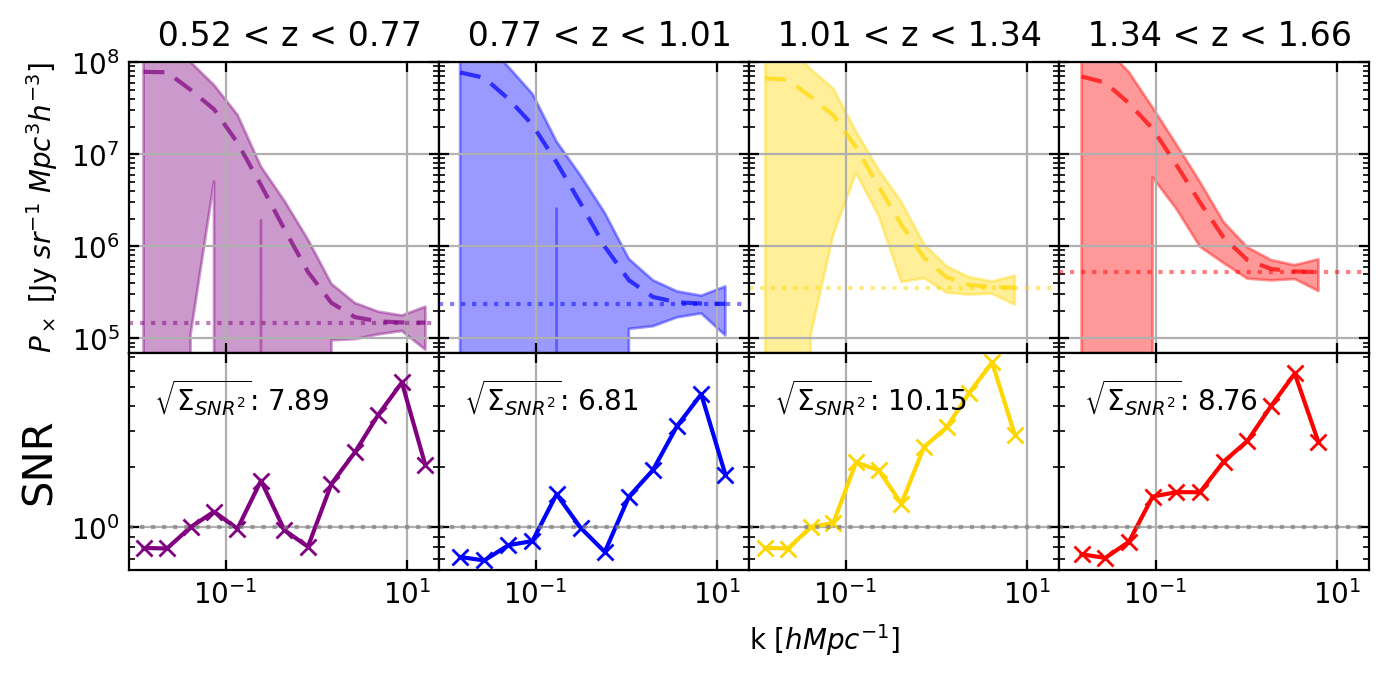

In [37]:
fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)

#plot Cross power as a function of k for each z bin, as well as SNR(k).
for i, PxG in enumerate(PxGs):
    power[i].loglog(Pms[i][0], PxG, color = colors[i], linestyle = '--', alpha = .7)
    power[i].axhline(x_shots[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], PxG + np.sqrt(VARx[i]),
                   PxG - np.sqrt(VARx[i]), color = colors[i], alpha = .4)
    #power[i].set_title('Bin'+str(i+1))
    power[i].set_title(f" {bins[i].front:.2f} < z < {bins[i].back:.2f}")

    SNR[i].loglog(Pms[i][0], SNR_PxG[i], color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_SNRs[i],2)))
    SNR[i].axhline(1, color = 'grey', ls = ":", alpha = .7)
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    #SNR[i].set_yticks(np.arange(0, 26, 4.0))
    leg = SNR[i].legend(prop={'size': 10}, handlelength=0, handletextpad=0, fancybox=True, loc = 'upper left')
    for item in leg.legendHandles:
        item.set_visible(False)

power[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 10)
power[0].set_ylim(7e4,1e8)

SNR[0].set_ylabel(r"SNR", size = 15)
#power[0].set_xlim(1.2e-1, 0.1e2)

#power[0].set_ylim(1e5, 1e7)
#SNR[0].set_ylim(0,25)
SNR[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=10, loc = 'left')
fig.subplots_adjust(hspace=0, wspace=0)

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

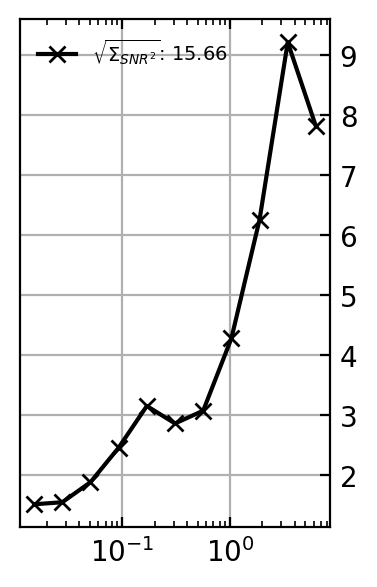

In [38]:
fig, total = plt.subplots(1,1, dpi = 200, figsize = (2,3.3))
total.semilogx(k4, np.sqrt(SNR_by_k), color = 'black', marker = 'x', 
        label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(totQuadSNR,2)))
total.grid()
total.legend(fontsize = 7)
total.yaxis.tick_right()

In [39]:
def quadsum(arr):
    return np.sqrt(np.sum(arr[~np.isnan(arr)]**2))

In [40]:
nGalList = np.logspace(-5, -2, 50)
SNRx_as_nGal = np.zeros(len(nGalList))

for i,n in enumerate(nGalList):
    x_shot = fs * Iciis[2] / n # cross shot for TIMxGal
    Pcross = (bstar * Iciis[2] * Igal * Pms[2][1]) + x_shots[2]
    
    VARxTIM = (Pcross**2 + (N_TIM[2] + P_TIM[2]) * (1/n +P_gal[2])) / (2*nModes[2])
    
    SNRx_as_nGal[i] = quadsum(Pcross / np.sqrt(VARxTIM))

In [41]:
save = False

if save: np.save('SNRx_as_nGal_TIM_Space', SNRx_as_nGal )

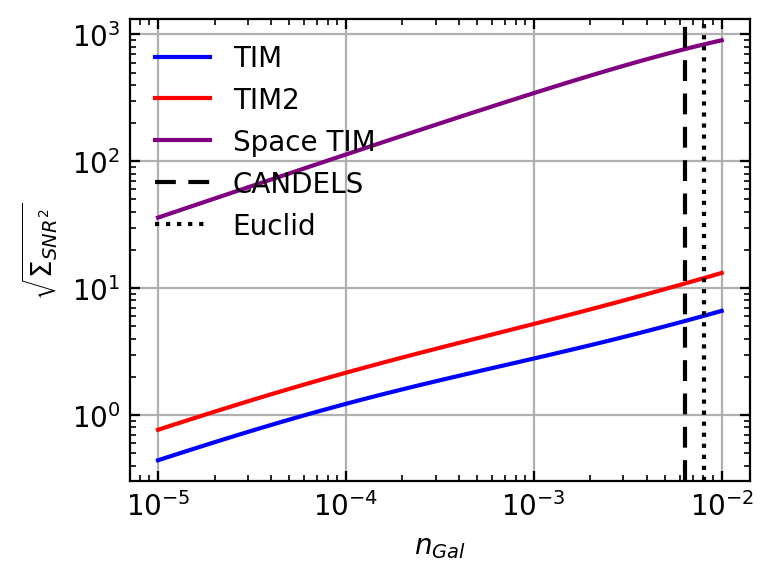

In [42]:
plt.figure(dpi = 200, figsize = (4,3))

TIM1 = np.load('SNRx_as_nGal_TIM_Vanilla.png.npy')
TIM2 = np.load('SNRx_as_nGal_TIM_Double_detector.npy')
TIMSpace = np.load('SNRx_as_nGal_TIM_Space.npy')

plt.loglog(nGalList, TIM1, label = 'TIM', ls = '-', color = 'blue')
plt.loglog(nGalList, TIM2, label = 'TIM2', ls = '-', color = 'red')
plt.loglog(nGalList, TIMSpace, label = 'Space TIM', ls = '-', color = 'purple')

plt.axvline(p.AstroDeep.n_gals[2], label = 'CANDELS', ls = '--', color = 'black')
plt.axvline(p.Euclid.n_gals[2], label = 'Euclid', ls = ':', color = 'black')

plt.xlabel(r'$n_{Gal}$')
plt.ylabel(r'$\sqrt{\Sigma_{SNR^2}}$')

plt.legend()
plt.grid()

In [43]:
#LWNEIARR = np.loadtxt('../TIM_LW_loading_space_4.5K.tsv')
#SWNEIARR = np.loadtxt('../TIM_SW_loading_space_4.5K.tsv')

In [44]:
#TIM.SW.NEI

In [45]:
#plt.loglog(LWNEIARR[:,0], LWNEIARR[:,2])
#plt.loglog(SWNEIARR[:,0], SWNEIARR[:,2])

#plt.grid()


In [46]:
#LWNEI = LWNEIARR[:,2].mean()
#SWNEI = SWNEIARR[:,2].mean()

#print('LW NEI: ', LWNEI)
#print('SW NEI: ', SWNEI)

In [47]:
spaceSig = []
spaceks = []
spaceNumks = []

TIM2Sig = []
TIM2ks = []
TIM2Numks = []

#TIMSig = []
spaceSig.append([np.asarray(np.load('TIMSpace_sig_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
spaceks.append([np.asarray(np.load('TIMSpace_k_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
spaceNumks.append([np.asarray(np.load('nModesSpace' + str(i+1) + '.npy')) for i in np.arange(4)])

TIM2Sig.append([np.asarray(np.load('TIM2_sig_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
TIM2ks.append([np.asarray(np.load('TIM2_k_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
TIM2Numks.append([np.asarray(np.load('nModesTIM2' + str(i+1) + '.npy')) for i in np.arange(4)])

#TIMSig.append([np.asarray(np.load('TIM2_sig_bin'+str(i+1)+'.npy')) for i in np.arange(4)])


In [48]:
spaceSig

[[array([6.19998412e+15, 6.18941302e+15, 1.40332801e+15, 5.27943546e+13,
         1.62753972e+12, 5.93353450e+10, 2.27248961e+09, 1.08203291e+08,
         9.63300447e+06, 2.43583713e+06, 1.25576797e+07]),
  array([6.01991758e+15, 4.78962979e+15, 1.45227905e+14, 9.12515773e+12,
         2.85598105e+11, 1.08295963e+10, 4.75769368e+08, 3.73117217e+07,
         8.27314386e+06, 3.99012930e+07]),
  array([4.46994657e+15, 4.07545438e+15, 9.47833641e+13, 4.48229285e+12,
         1.28787175e+11, 3.94652971e+09, 1.99886932e+08, 2.66514761e+07,
         9.29730042e+07]),
  array([4.91591146e+15, 3.76077392e+15, 5.33777619e+13, 3.85551666e+12,
         1.24385451e+11, 5.70763968e+09, 3.70765862e+08, 6.04227806e+07,
         2.45142683e+08])]]

In [49]:
len(spaceSig[0][0])

11

In [50]:
def modelPx(model_params):
    modelP = model_params[:,7]
    modelShot = model_params[:,8]
    return [xPow*Pm + shot for xPow, (_,Pm), shot in zip(modelP, Pms, modelShot)]
def modelICII(model_params):
    return model_params[:,0], model_params[:,1]
preface = './model_Params_from_simim/juzz_data_model_lcii_'
ICIIPreface = './model_Params_from_simim/juzz_icii_history_model_lcii_'


pessMax_params = modelPx(np.loadtxt(preface + 'sighigh.npy', delimiter=','))
pessMin_params = modelPx(np.loadtxt(preface + 'sfrumint.npy', delimiter=','))
optiMax_params = modelPx(np.loadtxt(preface + 'p19.npy', delimiter=','))
optiMin_params = modelPx(np.loadtxt(preface + 'h17um.npy', delimiter=','))
g12 = modelPx(np.loadtxt(preface + 'g12.npy', delimiter=','))
p19 = modelPx(np.loadtxt(preface + 'p19.npy', delimiter=','))
Y22 = modelPx(np.loadtxt(preface + 'Y22.npy', delimiter=','))

pessMax_ICII = modelICII(np.loadtxt(ICIIPreface + 'sighigh.csv', delimiter=','))
pessMin_ICII = modelICII(np.loadtxt(ICIIPreface + 'sfrumint.csv', delimiter=','))
optiMax_ICII = modelICII(np.loadtxt(ICIIPreface + 'p19.csv', delimiter=','))
optiMin_ICII = modelICII(np.loadtxt(ICIIPreface + 'h17um.csv', delimiter=','))
g12_ICII = modelICII(np.loadtxt(ICIIPreface + 'g12.csv', delimiter=','))
p19_ICII = modelICII(np.loadtxt(ICIIPreface + 'p19.csv', delimiter=','))
Y22_ICII = modelICII(np.loadtxt(ICIIPreface + 'Y22.csv', delimiter=','))

simimFiducial = modelPx(np.loadtxt(preface[:-1]+'.npy', delimiter=','))
simimICII = modelICII(np.loadtxt(ICIIPreface[:-1]+'.csv', delimiter=','))

In [51]:
os.listdir('./model_Params_from_simim')

['juzz_data_model_lcii.npy',
 'juzz_data_model_lcii_corrs12.npy',
 'juzz_data_model_lcii_corrs20.npy',
 'juzz_data_model_lcii_g12.npy',
 'juzz_data_model_lcii_h17ir.npy',
 'juzz_data_model_lcii_h17um.npy',
 'juzz_data_model_lcii_p19.npy',
 'juzz_data_model_lcii_sfrb17.npy',
 'juzz_data_model_lcii_sfrg13.npy',
 'juzz_data_model_lcii_sfrumint.npy',
 'juzz_data_model_lcii_sighigh.npy',
 'juzz_data_model_lcii_siglow.npy',
 'juzz_data_model_lcii_y22.npy',
 'juzz_icii_history_model_lcii.csv',
 'juzz_icii_history_model_lcii_corrs12.csv',
 'juzz_icii_history_model_lcii_corrs20.csv',
 'juzz_icii_history_model_lcii_g12.csv',
 'juzz_icii_history_model_lcii_h17ir.csv',
 'juzz_icii_history_model_lcii_h17um.csv',
 'juzz_icii_history_model_lcii_p19.csv',
 'juzz_icii_history_model_lcii_sfrb17.csv',
 'juzz_icii_history_model_lcii_sfrg13.csv',
 'juzz_icii_history_model_lcii_sfrumint.csv',
 'juzz_icii_history_model_lcii_sighigh.csv',
 'juzz_icii_history_model_lcii_siglow.csv',
 'juzz_icii_history_model_l

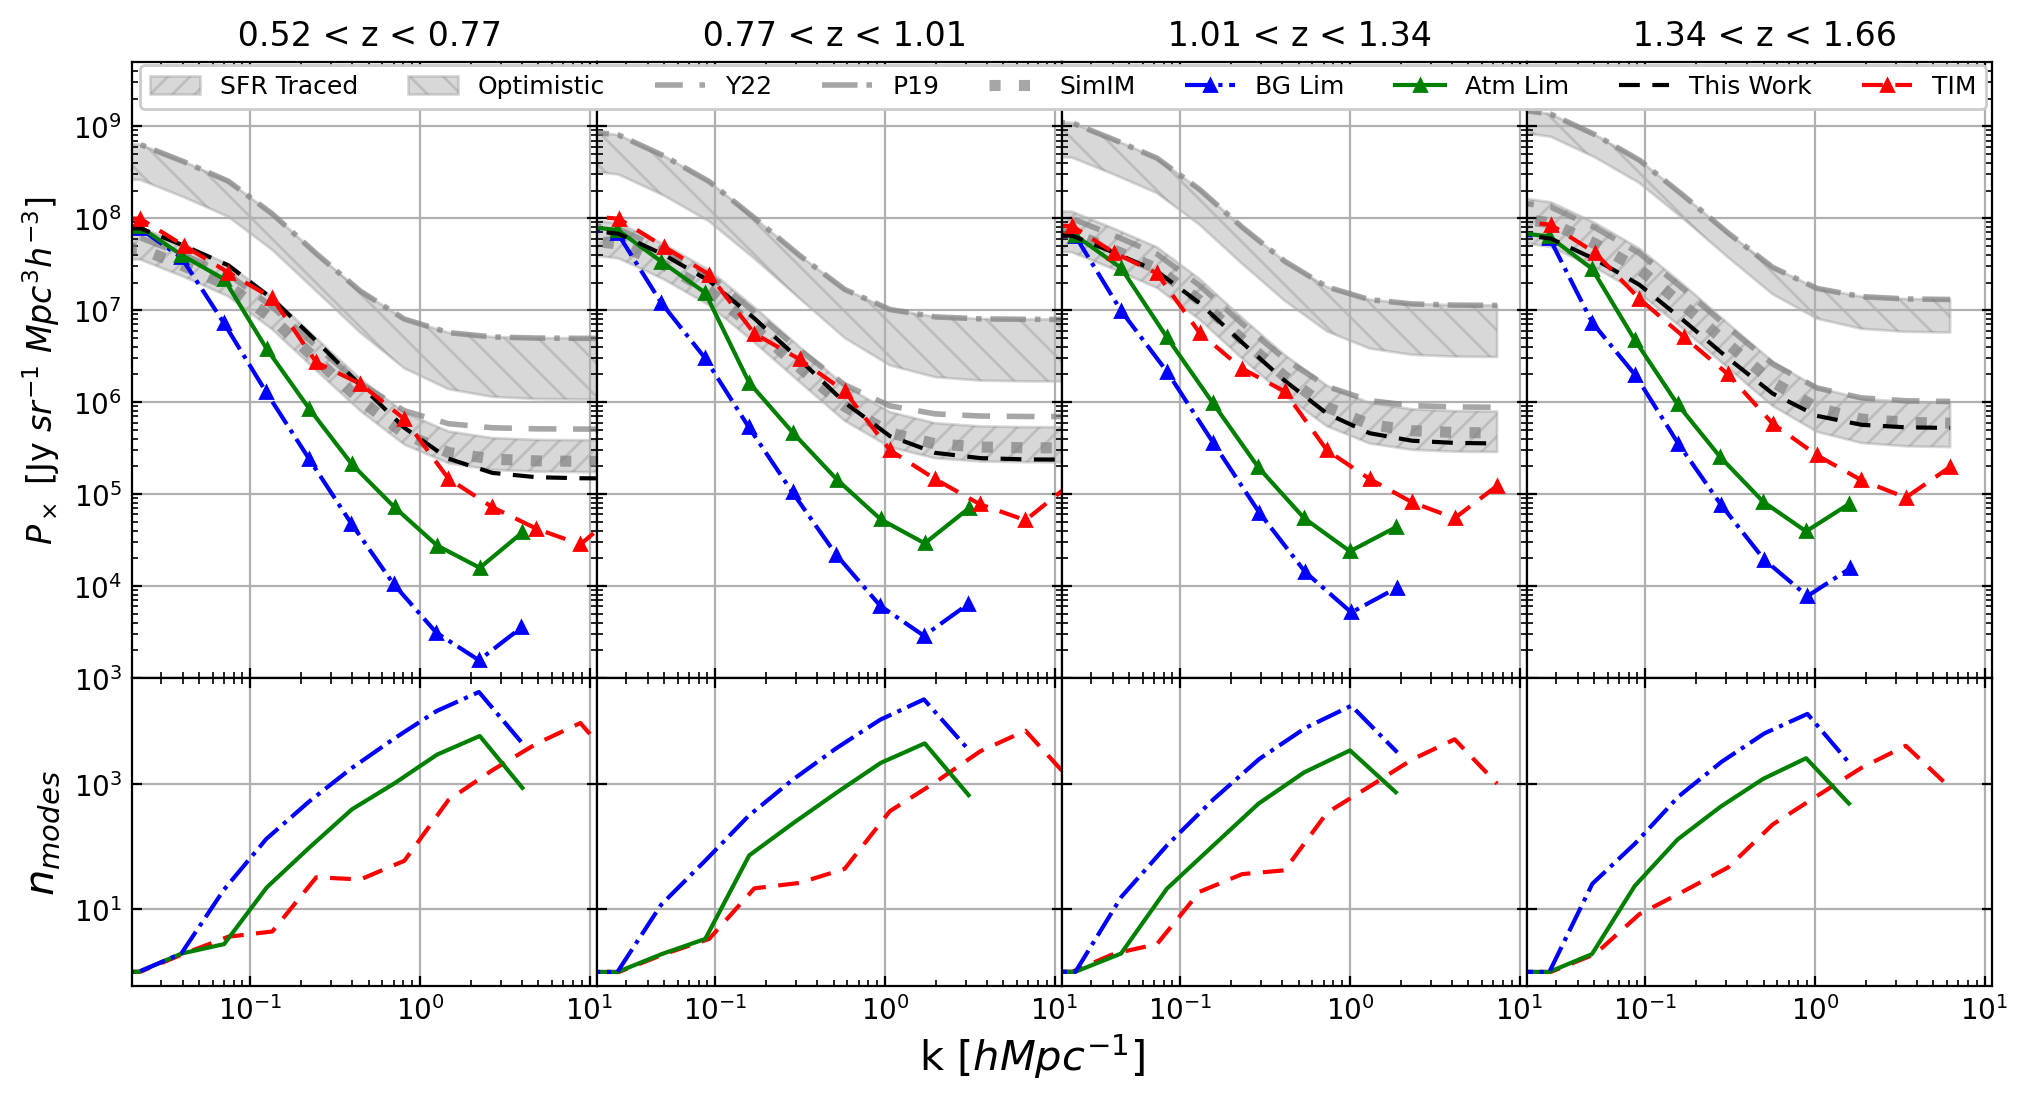

In [52]:
fig, (plots, kplots) = plt.subplots(2,4, figsize = (12, 6), dpi = 200, sharey = 'row', sharex = True,
                                    gridspec_kw={'height_ratios': [4,2]})

    
for i in np.arange(0,4):
    
    plots[i].fill_between(Pms[i][0], pessMax_params[i], pessMin_params[i], color = 'grey', alpha = 0.3, hatch = '///',
                          label = 'SFR Traced')
    plots[i].fill_between(Pms[i][0], optiMax_params[i], optiMin_params[i], color = 'grey', alpha = 0.3, hatch = '\\\\',
                          label = 'Optimistic')
    
    plots[i].loglog(Pms[i][0], Y22[i], label = 'Y22', ls = '--', lw = 2, color = 'grey', alpha = 0.7)
    plots[i].loglog(Pms[i][0], p19[i], label = 'P19', ls = '-.', lw = 2, color = 'grey', alpha = 0.7)
    #plots[i].loglog(Pms[i][0], g12[i], label = 'G12', ls = '--', lw = 2, color = 'forestgreen')
    
    plots[i].loglog(Pms[i][0], simimFiducial[i], color = 'grey', label = 'SimIM', ls = ':', lw = 4, alpha = 0.7)
    plots[i].loglog(spaceks[0][i], np.sqrt(spaceSig[0][i]), marker = '^', label = 'BG Lim', ms = 4,
                    color = 'blue', ls = '-.')
    plots[i].loglog(TIM2ks[0][i], np.sqrt(TIM2Sig[0][i]), marker = '^', label = 'Atm Lim', ms = 4,
                    color = 'green', ls = '-')
    plots[i].loglog(Pms[i][0], PxGs[i], color = 'k', linestyle = '--', label = 'This Work')
    #plots[i].loglog(Pms[i][0], np.sqrt(clusterVar[i]))
    #plots[i].loglog(Pms[i][0], P[i])
    #plots[i].loglog(Pms[i][0], np.sqrt(N_TIM[i]*P_gal[i]/(2*nModes[i])), label = r'$P_N P_{Gal} / 2n_{modes}$', ls = '--')
    plots[i].grid()
    kplots[i].grid()
    
    plots[i].set_title(f" {bins[i].front:.2f} < z < {bins[i].back:.2f}")
    kplots[i].loglog(Pms[i][0], nModes[i], color = 'r', marker = '', ls = '--')
    kplots[i].loglog(TIM2ks[0][i], TIM2Numks[0][i], color = 'green', marker = '', ms = 10, ls = '-')
    kplots[i].loglog(spaceks[0][i], spaceNumks[0][i], color = 'blue', marker = '', ls = '-.')
    

[plots[i].loglog(ks, np.sqrt(VARs), ls = '--', marker = '^', color = 'red', label = 'TIM', ms = 4) 
         for i, (VARs, (ks,_)) in enumerate(zip(VARx, Pms))]


#kplots[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=15, loc = 'left')
fig.text(0.5, 0.04, r"k [$h Mpc^{-1}]$", size=15, ha='center')
plots[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 12)
kplots[0].set_ylabel(r"$n_{modes}$", size = 15)
plots[2].set_xlim(2e-2,1.1e1)
plots[0].set_ylim(1e3,5e9)

plots[3].legend(loc='center right', bbox_to_anchor=(1.015, 0.96), frameon = True, fontsize = 9,
      ncol=9, fancybox=True, shadow=False, framealpha = 1)
#plots[0].legend(fontsize = 9)
#fig.subplots_adjust(hspace=0., wspace=0.06)
fig.subplots_adjust(hspace=0., wspace=0.00)

In [53]:
# Unify xranges, remove top xaxis, change handle length for y22 and p19

In [54]:
x_shots

array([147619.42691558, 236401.48333171, 353953.75946212, 521982.50630284])

In [63]:
#ICII_SNR_PxG = [SNR / (b_CII*b_gal*Ps) for (_,Ps), SNR in zip(Pms, SNR_PxG)]

#ICII_Sigs = [(np.sqrt(VARs))/(b_CII*b_gal*Ps) for (_,Ps), VARs, shot in zip(Pms, VARx, x_shots)]

ICII_Vars = [(b_CII*b_gal*Ps)**2/VARs for (_,Ps), VARs, shot in zip(Pms, VARx, x_shots)]

ICIISigsTot = [np.sqrt(1/np.sum(IVar)) for IVar in ICII_Vars]

#ICIISigsTot = [quadsum(SNRs) for SNRs in ICII_Sigs]

In [66]:
ICII_Vars

[array([1.10896908e-07, 1.09647499e-07, 1.77788973e-07, 2.52719398e-07,
        1.69054025e-07, 4.85739252e-07, 1.36344221e-07, 5.93372158e-08,
        7.40100609e-08, 1.72001003e-08, 2.52127000e-09, 2.55923581e-10,
        1.69576155e-12]),
 array([6.27486655e-08, 5.78963553e-08, 8.16554740e-08, 8.88744394e-08,
        2.49616561e-07, 1.03713253e-07, 4.10665351e-08, 5.00302156e-08,
        1.16599287e-08, 2.01143006e-09, 1.95062099e-10, 1.29246823e-12]),
 array([6.08209452e-08, 5.97007622e-08, 9.67433574e-08, 1.05746182e-07,
        4.07870841e-07, 3.06289105e-07, 1.06308837e-07, 1.71433473e-07,
        5.11179632e-08, 1.02762454e-08, 1.28954736e-09, 1.32406291e-11]),
 array([5.02101031e-08, 4.60431268e-08, 6.58825221e-08, 1.80079567e-07,
        1.83286258e-07, 1.43352728e-07, 1.42268276e-07, 4.74010314e-08,
        9.57724031e-09, 1.18041957e-09, 1.19117367e-11])]

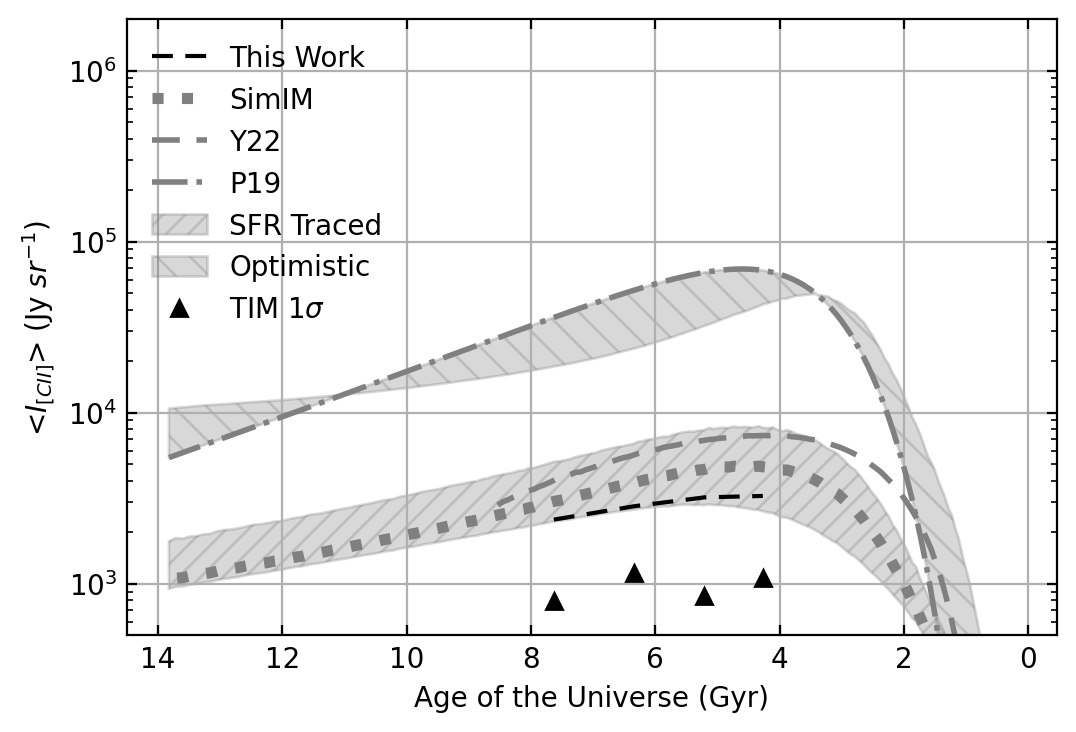

In [65]:
ages = cosmo.age(simimICII[0]).value

plt.figure(dpi = 200, figsize = [6,4])
plt.semilogy(cosmo.age(bin_zs).value, Iciis, color = 'k', ls = '--', label = 'This Work')

plt.semilogy(cosmo.age(simimICII[0]), simimICII[1], color = 'grey', label = 'SimIM', ls = ':', lw = 4)
plt.semilogy(cosmo.age(Y22_ICII[0]), Y22_ICII[1], label = 'Y22', ls = '--', lw = 2, color = 'grey')
plt.semilogy(cosmo.age(p19_ICII[0]), p19_ICII[1], label = 'P19', ls = '-.', lw = 2, color = 'grey')
plt.fill_between(cosmo.age(pessMax_ICII[0]).value, pessMax_ICII[1], pessMin_ICII[1], color = 'grey', alpha = 0.3, hatch = '///',
                          label = 'SFR Traced')
plt.fill_between(cosmo.age(optiMax_ICII[0]).value, optiMax_ICII[1], optiMin_ICII[1], color = 'grey', alpha = 0.3, hatch = '\\\\',
                          label = 'Optimistic')

#plt.semilogy(cosmo.age(bin_zs).value, 3*Iciis/quad_SNRs_Clust, color = 'k', ls = '', marker = '^',  label = r'TIM $3\sigma$')
plt.semilogy(cosmo.age(bin_zs).value, np.asarray(ICIISigsTot), color = 'k', ls = '', marker = '^',  label = r'TIM $1\sigma$')



plt.ylim(5e2, 2e6)
#plt.xlim(0.5,1.7)

plt.gca().invert_xaxis()
plt.xlabel("Age of the Universe (Gyr)")
plt.ylabel(r"<$I_{[CII]}$> (Jy $sr^{-1}$)")
#plt.legend(loc='center right', bbox_to_anchor=(0.9115, 0.92), frameon = True, fontsize = 8,
#      ncol=4, fancybox=True, shadow=False)
plt.legend()
plt.grid()


#for 3sigma TIM I use only quad SNR from ks < 1. So only clustering. 

In [58]:
saveSig = False
if saveSig:
    for i in [1,2,3,4]:
        #np.save('TIMSpace_sig_bin' + str(i) + '.npy', VARx[i-1])
        #np.save('TIMSpace_k_bin' + str(i) + '.npy', Pms[i-1][0])
        #np.save('nModesSpace' + str(i) + '.npy', nModes[i-1])
        
        np.save('TIM2_sig_bin' + str(i) + '.npy', VARx[i-1])
        np.save('TIM2_k_bin' + str(i) + '.npy', Pms[i-1][0])
        np.save('nModesTIM2' + str(i) + '.npy', nModes[i-1])
        
        #clusterVar
        #np.save('clustVar' + str(i) + '.npy', clusterVar[i-1])

In [59]:
saveICIISig = True
if saveICIISig:
    #np.save('TIMSpace_ICIIsig_bin' + str(i) + '.npy', ICIISigsTot)
    #np.save('TIMSpace_ICIIk_bin' + str(i) + '.npy', cosmo.age(bin_zs).value)

    np.save('TIM2_ICIIsigs' + str(i) + '.npy', ICIISigsTot)
    np.save('TIM2_ICII_Ages' + str(i) + '.npy', cosmo.age(bin_zs).value)
        
#cosmo.age(bin_zs).value, np.asarray(ICIISigs)

In [60]:
[plt.loglog(ks, Px) for (ks,_), Px in zip(Pms, ModelPx)]

NameError: name 'ModelPx' is not defined

In [ ]:
midks = Pms[2][0]
midPm = Pms[2][1]

In [ ]:
len(Pms[0][1])

In [ ]:
[print(len(var)) for var in VARx]

In [ ]:
len(np.load('TIMSpace_sig_bin4.npy'))

In [ ]:
for i in [1,2,3,4]:
    print(len(VARx[i-1]))

In [ ]:
np.load('TIMSpace_sig_bin4.npy')